In [33]:
!pip install numpy matplotlib scikit-learn scipy

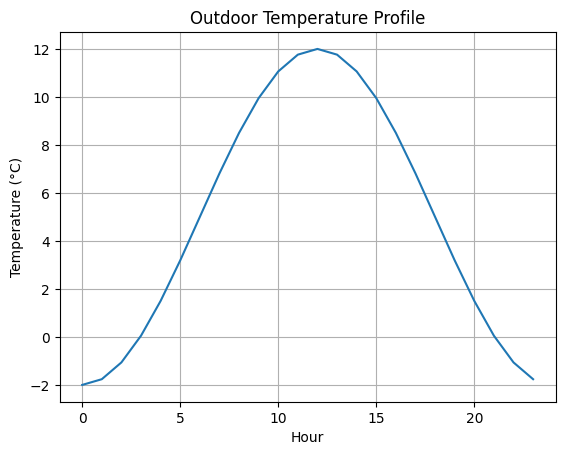

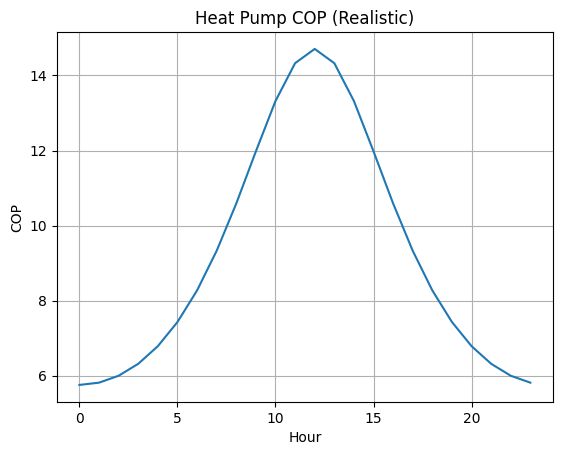

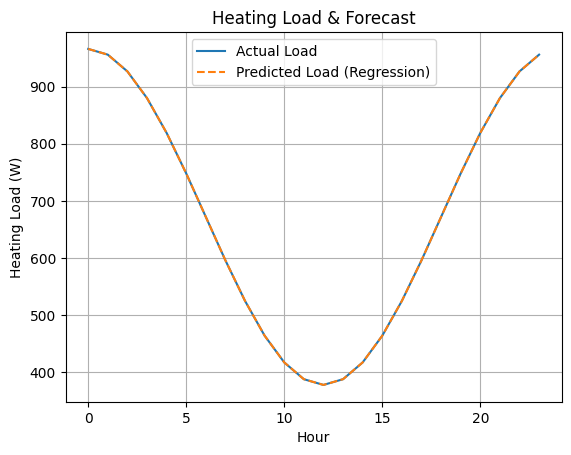

Using T_min = 25 T_set = 45
Solver success: True - The solver successfully reached the end of the integration interval.


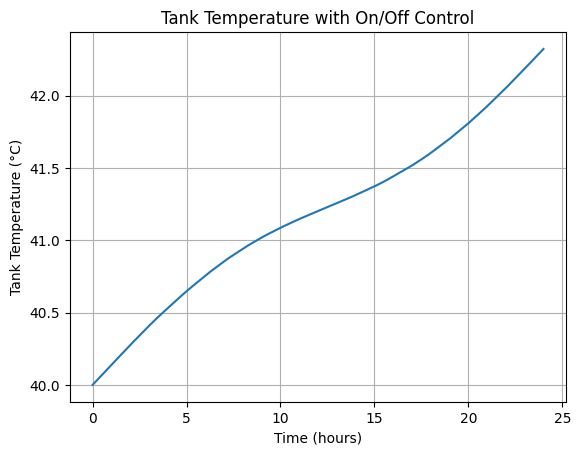

Average COP: 9.200177234233289
Seasonal-like COP proxy (Q/P): 7.550374331550804
System efficiency ratio (Q/P vs mean COP): 0.821
Heat pump ON time (% of day): 100.0 %
Total Daily Heating Energy (kWh): 16.128
Total Daily Electric Energy (kWh): 2.136053034166241
Daily Average Tank Temperature: 41.18121418945066
Maximum Tank Temperature: 42.323361885047994
Minimum Tank Temperature: 40.0


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -----------------------------
# Building Parameters
# -----------------------------
U = 0.35          # W/m²K
A = 120           # m²
T_indoor = 21     # °C
efficiency = 0.45 # Realistic heat pump efficiency factor

# -----------------------------
# Simulated 24-hour temperature profile
# -----------------------------
hours = np.arange(0, 24, 1)
T_outdoor = 5 + 7 * np.sin((hours - 6) * np.pi / 12)  # daily variation

T_hot = T_indoor + 273.15
T_cold = T_outdoor + 273.15

# -----------------------------
# Heating Load Calculation
# -----------------------------
Q_heating = U * A * (T_indoor - T_outdoor)
Q_heating[Q_heating < 0] = 0

# -----------------------------
# Heat Pump COP (Realistic)
# -----------------------------
COP_carnot = T_hot / (T_hot - T_cold)
COP_real = efficiency * COP_carnot
COP_real[COP_real < 1] = 1

# -----------------------------
# Electrical Power Consumption
# -----------------------------
P_electric = Q_heating / COP_real
# -----------------------------
# Daily Energy Calculation
# -----------------------------
dt_hours = 1  # because hours = np.arange(0, 24, 1)

daily_heating_kwh = np.sum(Q_heating) * dt_hours / 1000
daily_electric_kwh = np.sum(P_electric) * dt_hours / 1000


# -----------------------------
# Regression Forecasting
# -----------------------------
X = T_outdoor.reshape(-1, 1)
y = Q_heating

model = LinearRegression()
model.fit(X, y)
Q_pred = model.predict(X)

# -----------------------------
# Plot Results
# -----------------------------
plt.figure()
plt.plot(hours, T_outdoor)
plt.title("Outdoor Temperature Profile")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()

plt.figure()
plt.plot(hours, COP_real)
plt.title("Heat Pump COP (Realistic)")
plt.xlabel("Hour")
plt.ylabel("COP")
plt.grid()
plt.show()

plt.figure()
plt.plot(hours, Q_heating, label="Actual Load")
plt.plot(hours, Q_pred, linestyle="--", label="Predicted Load (Regression)")
plt.title("Heating Load & Forecast")
plt.xlabel("Hour")
plt.ylabel("Heating Load (W)")
plt.legend()
plt.grid()
plt.show()
from scipy.integrate import solve_ivp

# -----------------------------
# Thermal Storage Parameters
# -----------------------------
m = 300          # kg of water
Cp = 4186        # J/kg.K
T_initial = 40   # °C (initial tank temperature)
T_set = 45       # °C (control setpoint)
T_min = 25  # °C, minimum tank temperature safeguard

# Time for ODE simulation (0 to 24 hours)
time_hours = np.linspace(0, 24, 200)
time_seconds = time_hours * 3600


def tank_model_controlled(t, T):
    T = float(T[0]) if np.ndim(T) > 0 else float(T)

    hour_index = int(np.floor(t / 3600)) % 24
    Q_demand = float(Q_heating[hour_index])

    # ON if below setpoint OR below minimum safeguard
    if (T < T_set) or (T <= T_min):
        Q_supply = 1.05 * Q_demand
    else:
        Q_supply = 0.0

    return (Q_supply - Q_demand) / (m * Cp)

print("Using T_min =", T_min, "T_set =", T_set)

sol = solve_ivp(
    tank_model_controlled,
    t_span=(time_seconds[0], time_seconds[-1]),
    y0=[T_initial],
    t_eval=time_seconds,
    method="RK45",
    rtol=1e-6,
    atol=1e-8
)
T_tank_controlled = sol.y[0]

print("Solver success:", sol.success, "-", sol.message)

# =============================
# SYSTEM PERFORMANCE SUMMARY
# =============================

# -----------------------------
# Performance Metrics
# -----------------------------
on_fraction = np.mean(T_tank_controlled < T_set)
seasonal_cop_proxy = np.sum(Q_heating) / np.sum(P_electric)


# Plot tank temperature
plt.figure()
plt.plot(time_hours, T_tank_controlled)
plt.title("Tank Temperature with On/Off Control")
plt.xlabel("Time (hours)")
plt.ylabel("Tank Temperature (°C)")
plt.grid(True)
plt.show()


print("Average COP:", np.mean(COP_real))
print("Seasonal-like COP proxy (Q/P):", seasonal_cop_proxy)
print("System efficiency ratio (Q/P vs mean COP):",
      round(seasonal_cop_proxy / np.mean(COP_real), 3))
print("Heat pump ON time (% of day):", round(on_fraction * 100, 2), "%")
print("Total Daily Heating Energy (kWh):", daily_heating_kwh)
print("Total Daily Electric Energy (kWh):", daily_electric_kwh)
print("Daily Average Tank Temperature:", np.mean(T_tank_controlled))
print("Maximum Tank Temperature:", np.max(T_tank_controlled))
print("Minimum Tank Temperature:", np.min(T_tank_controlled))
